In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
import seaborn as sns
from tqdm import tqdm
from torch.nn import Parameter
import scipy.io as sio
import scipy.stats as ss
import itertools
from torch import nn
import torch.nn.functional as F
from sklearn.neighbors import KernelDensity
import time
import matplotlib as mpl
from matplotlib import colors
import os

plt.rc('text', usetex=True)
font = {
    'family' : 'serif',
    'weight' : 'normal',
    'size'   : 10}
plt.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def simulator(alphas,betas,gammas,S=100, T=100, mu=0, sigma=0, seed=-1,is_plot=0,buffer=20):
    '''
    Generate the time-varying simulated data
    Params
    *alphas:  list[2d+1], coupling coefficients for Y
    *betas: list[2d+2], coupling coefficients for A
    *gammas: list[2d+1], coupling coefficients for L (W in the paper)
    *S: number of individuals
    *T: number of time points per individual
    *mu, sigma: mean/std of the observational noise for Y
    *seed: random seed
    *is_plot: if plot simulated data 
    '''
    if seed >=0:
        np.random.seed(seed)
    d= int((len(betas)-2)/2)
    Y = np.zeros([S,T-d+1])
    L = np.zeros([S,T])
    A = np.zeros([S,T])
    f = np.zeros([S,T])
    #initial L is uniform
    L[:,0] = np.random.uniform(size=S)
    f[:,0] = sigmoid(betas[0]+betas[1]*L[:,0])
    A[:,0] = np.random.binomial(1,f[:,0])

    for t in range(1,d):
        L[:,t] = gammas[0]+A[:,:t]@gammas[1:1+t]+L[:,:t]@gammas[1+d:1+d+t]
        f[:,t] = sigmoid(betas[0]+A[:,:t]@betas[1:1+t]+L[:,:t+1]@betas[1+d:2+d+t])
        A[:,t] = np.random.binomial(1,f[:,t])

    for t in range(d,T):
        L[:,t] = gammas[0]+A[:,t-d:t]@gammas[1:1+d]+L[:,t-d:t]@gammas[1+d:]
        f[:,t] = sigmoid(betas[0]+A[:,t-d:t]@betas[1:1+d]+L[:,t-d:t+1]@betas[1+d:])
        A[:,t] = np.random.binomial(1,f[:,t])
        Y[:,t-d] = alphas[0] + A[:,t-d:t]@alphas[1:1+d]+ L[:,t-d:t]@alphas[1+d:]
    Y[:,-1] = alphas[0] + A[:,T-d:T]@alphas[1:1+d]+ L[:,T-d:T]@alphas[1+d:]
    
    if sigma>0:
        Y=Y+np.random.normal(mu,sigma,Y.shape) 

    #return by squeezing the time and individual dims
    L_,f_,A_ = np.zeros([S,T-d+1,d]),np.zeros([S,T-d+1,d]),np.zeros([S,T-d+1,d])
    for kk in range(T-d+1):
        L_[:,kk] = L[:,kk:kk+d]
        f_[:,kk] = f[:,kk:kk+d]
        A_[:,kk] = A[:,kk:kk+d]    
    simu_data =  [Y[:,:],L_[:,:],A_[:,:],f_[:,:]]
    if is_plot:
        plot_simu(simu_data)
    
    Y,L,A,f = Y[:,buffer:].reshape(-1,order='C'),L_[:,buffer:].reshape(-1,d,order='C'),A_[:,buffer:].reshape(-1,d,order='C'),f_[:,buffer:].reshape(-1,d,order='C')
    simu_data = [Y,L,A,f]
    return(simu_data)


def simu_unconfounded(alphas,betas,gammas,at=None,S=100, T=100, mu=0, sigma=0, seed=-1,is_plot=0):
    '''
    Generate the counterfactual outcome distribution (Algo 3, Appendix E3)
    Params
    *alphas:  list[2d+1], coupling coefficients for Y
    *betas: list[2d+2], coupling coefficients for A
    *gammas: list[2d+1], coupling coefficients for L (W in the paper)
    *S: number of individuals
    *T: number of time points per individual
    *mu, sigma: mean/std of the observational noise for Y
    *seed: random seed
    *is_plot: if plot simulated data 
    '''
    if seed >=0:
        np.random.seed(seed)
    d= int((len(betas)-2)/2)
    Y = np.zeros([S,T-d+1])
    L = np.zeros([S,T])
    f = np.zeros([S,T])
    
    A = np.zeros([S,T])
    #initial L is uniform
    L[:,0] = np.random.uniform(size=S)
    f[:,0] = sigmoid(betas[0]+betas[1]*L[:,0])
    A[:,0] = np.random.binomial(1,f[:,0])

    for t in range(1,d):
        L[:,t] = gammas[0]+A[:,:t]@gammas[1:1+t]+L[:,:t]@gammas[1+d:1+d+t]
        f[:,t] = sigmoid(betas[0]+A[:,:t]@betas[1:1+t]+L[:,:t+1]@betas[1+d:2+d+t])
        A[:,t] = np.random.binomial(1,f[:,t])

    for t in range(d,T-d):
        L[:,t] = gammas[0]+A[:,t-d:t]@gammas[1:1+d]+L[:,t-d:t]@gammas[1+d:]
        f[:,t] = sigmoid(betas[0]+A[:,t-d:t]@betas[1:1+d]+L[:,t-d:t+1]@betas[1+d:])
        A[:,t] = np.random.binomial(1,f[:,t])
        Y[:,t-d] = alphas[0] + A[:,t-d:t]@alphas[1:1+d]+ L[:,t-d:t]@alphas[1+d:]
    A[:,T-d:] = at
    for t in range(T-d,T):
        L[:,t] = gammas[0]+A[:,t-d:t]@gammas[1:1+d]+L[:,t-d:t]@gammas[1+d:]
        Y[:,t-d] = alphas[0] + A[:,t-d:t]@alphas[1:1+d]+ L[:,t-d:t]@alphas[1+d:]
    Y[:,-1] = alphas[0] + A[:,T-d:T]@alphas[1:1+d]+ L[:,T-d:T]@alphas[1+d:]
    
    if sigma>0:
        Y=Y+np.random.normal(mu,sigma,Y.shape) 

    return(Y[:,-1])

def plot_simu(simu_data):
    '''
    Plot simulated data
    '''
    Y,L,A,f = simu_data
    d = A.shape[-1]
    fig,ax = plt.subplots(1,4, figsize=(12,2.5))
    data_to_plot = [Y,L,A,f]
    labels = ['Y','L','A','f']
    for i in range(4):
        if i==0:
            ax[i].plot((data_to_plot[i][:3,:150]).T)
        else:
            ax[i].plot((data_to_plot[i][:3,:150,-1]).T)
        ax[i].set_ylabel(labels[i])
        ax[i].set_xlabel('Time')
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

    Y,L,A,f = Y.reshape(-1,order='C'),L.reshape(-1,d,order='C'),A.reshape(-1,d,order='C'),f.reshape(-1,d,order='C')

    fig,ax = plt.subplots(1,4, figsize=(12,2.5))
    data_to_plot = [Y,L,A,f]
    for i in range(4):
        ax[i].hist(data_to_plot[i].flatten(),bins=100)
        ax[i].set_xlabel(labels[i])
        ax[i].set_ylabel('count')
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

    A_unique = np.unique(A,axis=0)
    Y_trues = []     
    for a in A_unique:
        inds  = np.where(np.all(A==a,axis=1)) 
        Y_trues.append(Y[inds])

    for cnt in range(len(A_unique)):
        plt.hist(Y_trues[cnt],alpha = 0.8,bins=50, label='true dist',density=True)

        plt.title('A='+str(A_unique[cnt]) + '\n proportion = %.2f'%(len(Y_trues[cnt])/len(Y)) + '\n mean = %.2f'%(Y_trues[cnt].mean()))

        plt.xlabel('Y')
        plt.ylabel('count')

        plt.show()

def generate_train_test(simu_data,train_size,test_size,seed =-1):
    '''
    Generate the training and validation data for training CVAE/MSCVAE
    '''
    if seed >=0:
        np.random.seed(seed)
    Y,L,A,f = simu_data
    d = A.shape[-1]
    if len(Y.shape)>1:
        Y,L,A,f = Y.reshape(-1,order='C'),L.reshape(-1,d,order='C'),A.reshape(-1,d,order='C'),f.reshape(-1,d,order='C')
    inds = np.random.permutation(range(len(Y)))
    Y,L,A,f = Y[inds],L[inds],A[inds],f[inds]

    sim_data_y_train=torch.Tensor(A[:train_size])
    sim_data_y_test=torch.Tensor(A[train_size:train_size+test_size])

    sim_data_x_train=torch.Tensor(Y[:train_size])[:,None]
    sim_data_x_test=torch.Tensor(Y[train_size:train_size+test_size])[:,None]

    w_train = np.prod(1/(np.multiply(f[:train_size],A[:train_size])+np.multiply(1-f[:train_size],1-A[:train_size])),axis=1)
    w_train=clip_w(w_train,0.01,99.99,True)
    w_train=torch.Tensor(w_train)
    training_set  = [sim_data_y_train,sim_data_y_test,sim_data_x_train,sim_data_x_test,w_train]
    return(training_set)

class CVAE(nn.Module):
    def __init__(self, input_size, labels_length,hidden_size=20, layer_width = 128):
        super(CVAE, self).__init__()
        self.hidden_size = hidden_size
        self.input_size=input_size
        self.labels_length=labels_length
        input_size_with_label = self.input_size + self.labels_length
        self.layer_width=layer_width
        
        self.fc1 = nn.Linear(input_size_with_label,self.layer_width)
        self.fc21 = nn.Linear(self.layer_width, hidden_size)
        self.fc22 = nn.Linear(self.layer_width, hidden_size)
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size+self.labels_length, self.layer_width)
        self.fc4 = nn.Linear(self.layer_width, input_size)
    
    def encode(self, x, labels):
        x = x.view(-1, self.input_size)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z, labels):
        z = torch.cat((z, labels), 1)
        z = self.relu(self.fc3(z))
        return self.fc4(z)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, labels)
        return x, mu, logvar



def vae_loss_fn(x, recon_x, mu, logvar,w_train):
    
    if  w_train is None: # for the unweighted loss
        BCE = F.mse_loss(recon_x, x, reduction='mean')
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD
    else: # for the weighted loss
        BCE = (F.mse_loss(recon_x, x, reduction='none')*w_train[:,None]).mean()
        KLD = -0.5 * torch.mean((1 + logvar - mu.pow(2) - logvar.exp())*w_train[:,None])
        return BCE + KLD

def clip_w(w,a=1,b=99,mean_norm=True):
    #clip the IPTW weights to to percentiles within [a,b] and normalize them by means.
    if a>0 or b<100:
        a,b = np.percentile(w.flatten(),[a,b])
        w = np.clip(w,a,b)
    if mean_norm:
        w=w/w.mean()
    return(w)

def train(training_set, hidden_size=64,layer_width=128,epochs=60,batch_size = 256,is_msm=0,learning_rate = 0.001,seed = -1):
    '''
    Train the CVAE/MSCVAE
    Params
    *training_set:  set of training and testing data
    *hidden_size: hidden size (latent dim) for the autoencoder
    *layer_width: width of the hidden layer
    *epochs: number of training epochs
    *batch_size: training batch size
    *is_msm: =0 for CVAE, =1 for MSCVAE
    *learning_rate: training learning rate
    *seed : random seed
    '''
    if seed >=0:
        np.random.seed(seed)
    sim_data_y_train,sim_data_y_test,sim_data_x_train,sim_data_x_test,w_train = training_set 
    if is_msm:
        plt.hist(w_train.detach().numpy(),bins=100)
        plt.xlabel('weights')
        plt.ylabel('count')
        plt.show()
    
    input_size = sim_data_x_train.shape[-1]
    labels_length = sim_data_y_train.shape[-1]
    
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', DEVICE)
    
    cvae = CVAE(input_size,labels_length,hidden_size,layer_width).to(DEVICE)
    validation_losses = []
    train_losses = []
    optim = torch.optim.Adam(cvae.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=int(epochs/3), gamma=0.5)
    n_batch = int(len(sim_data_x_train)/batch_size)
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch in range(n_batch):
                optim.zero_grad()
                train_x = sim_data_x_train[batch*batch_size:(batch+1)*batch_size]
                train_y = sim_data_y_train[batch*batch_size:(batch+1)*batch_size]
                x,mu,logvar = cvae(train_x,train_y)
                if is_msm:
                    loss = vae_loss_fn(train_x, x, mu, logvar,w_train[batch*batch_size:(batch+1)*batch_size])
                else:
                    loss = vae_loss_fn(train_x, x, mu, logvar,None)
                if i%50 ==0:
                    train_losses.append(loss.detach().numpy())
                    x_test,mu_test,logvar_test = cvae(sim_data_x_test,sim_data_y_test)
                    validation_losses.append(vae_loss_fn(sim_data_x_test, x_test, mu_test, logvar_test,None).detach().numpy())
                        
                loss.backward()
                optim.step()
            scheduler.step()
            pbar_outer.update(1)
    val_err = np.mean(validation_losses[-10:])
    print('validation err: ' + str(val_err))
    return(cvae,train_losses,validation_losses)




def draw_samples(simu_settings,cvae,cvae_w,training_set):
    '''
    Obtain samples from the trained CVAE/MSCVAE
    Params
    *simu_settings:  simulation parameters
    *cvae: trained CVAE
    *cvae_w: trained MSCVAE
    *training_set: set of training and testing data
    '''
    d,ycoeff,acoeff,lcoeff,mu,sigma,_,_,_ = simu_settings
    n_reap=10000
    S_causal=n_reap
    T_causal=100
    Y_trues_simu = []
    cvae_sample = [] 
    cvae_w_sample = []  

    
    Y_train = np.squeeze(training_set[2].numpy())
    w_train = np.squeeze(training_set[-1].numpy())
    A_train = training_set[0].numpy()
    hidden_size = cvae.hidden_size
    A_unique = list(itertools.product([0, 1], repeat=d))
    
    for a in A_unique:
        if d == 1:
            inds  = np.where(A_train==a)[0]#for d=1
        else:
            inds  = np.where(np.all(A_train==a,axis=1))#for d>1
             
        tmp = cvae.decode(torch.Tensor(np.random.randn(n_reap, hidden_size)),torch.Tensor(a).repeat(n_reap,1))
        cvae_sample.append(tmp.detach().numpy()) 
        
        tmp = cvae_w.decode(torch.Tensor(np.random.randn(n_reap, hidden_size)),torch.Tensor(a).repeat(n_reap,1))
        cvae_w_sample.append(tmp.detach().numpy())
        
        Y_trues_simu.append(simu_unconfounded(ycoeff,acoeff,lcoeff,a,S_causal, T_causal, mu, sigma, seed=-1, is_plot=1))
    return(Y_trues_simu,cvae_sample,cvae_w_sample)





def plot_compute(d,Y_trues_simu,cvae_sample,cvae_w_sample,figname):
    '''
    Visualize and return simulation results
    Params
    *d:  length of history dependence
    *Y_trues_simu: counterfactual outcome distribution
    *cvae_sample/cvae_w_sample: outcome samples from the trained CVAE/MSCVAE
    *figname: name for saving figures
    '''
    print('d=%d'%(d))
    if d ==1:
        fig, axs = plt.subplots(2,1,figsize=(1.7,3.5))
        nrow=2
        ncol=1
        
    elif d == 2:  
        fig, axs = plt.subplots(2,2,figsize=(3.5,3.5))
        nrow=2
        ncol=2
        
    elif d == 3:  
        fig, axs = plt.subplots(2,4,figsize=(6.5,3.5))
        nrow=2
        ncol=4
        
    elif d == 4:  
        fig, axs = plt.subplots(4,4,figsize=(6.5,6))
        nrow=4
        ncol=4
    elif d ==5:
        fig, axs = plt.subplots(4,8,figsize=(10,6))
        nrow=4
        ncol=8
    dmax = 0
    cnt=0
    md_cvae = []
    wd_cvae = []
    tv_cvae = []
    md_mscvae = []
    wd_mscvae = []
    tv_mscvae = []

    A_unique = list(itertools.product([0, 1], repeat=d))

    for i in range(nrow):
        for j in range(ncol):

            if d == 1:
                axs[cnt].spines['right'].set_visible(False)
                axs[cnt].spines['top'].set_visible(False)
                axs[cnt].tick_params(left = False, right = False , labelleft = False)

            else:
                axs[i,j].spines['right'].set_visible(False)
                axs[i,j].spines['top'].set_visible(False)
                axs[i,j].tick_params(left = False, right = False , labelleft = False)

            hists = np.histogram(Y_trues_simu[cnt],density=True,bins=100)
            (dens_true, cutoffs) = hists[0],hists[1]
            if d==1:
                axs[cnt].plot((cutoffs[1:]+cutoffs[:-1])/2,dens_true,label=r'\texttt{True}',color='k',linewidth=2,alpha=1)
            else:
                axs[i,j].plot((cutoffs[1:]+cutoffs[:-1])/2,dens_true,label=r'\texttt{True}',color='k',linewidth=2,alpha=1)
            dmax=max(dmax,np.max(dens_true))

            if d==1:
                hists = axs[cnt].hist(cvae_sample[cnt],density=True,bins=100,label=r'\texttt{CVAE}',color='grey',alpha=0.7)
            else:
                hists = axs[i,j].hist(cvae_sample[cnt],density=True,bins=100,label=r'\texttt{CVAE}',color='grey',alpha=0.7)
            (dens, cutoffs) = hists[0],hists[1]
            dmax=max(dmax,np.max(dens))
            tv_cvae.append(np.abs(dens_true-dens).mean())

            if d==1:
                hists = axs[cnt].hist(cvae_w_sample[cnt],density=True,bins=100,label=r'\texttt{MSCVAE}',color='orangered',alpha=0.7)
            else:   
                hists = axs[i,j].hist(cvae_w_sample[cnt],density=True,bins=100,label=r'\texttt{MSCVAE}',color='orangered',alpha=0.7)
            (dens, cutoffs) = hists[0],hists[1]
            dmax=max(dmax,np.max(dens))
            tv_mscvae.append(np.abs(dens_true-dens).mean())


            if d==1:
                axs[cnt].set_title(r'$\overline{a}=$('+','.join([str(int(a)) for a in str(A_unique[cnt]) if a.isdigit()])+')')
                axs[cnt].set_ylim([0,dmax])
            else:  
                axs[i,j].set_title(r'$\overline{a}=$('+','.join([str(int(a)) for a in str(A_unique[cnt]) if a.isdigit()])+')')
                axs[i,j].set_ylim([0,dmax])

                #axs[i,j].set_title(r'$\overline{a}=$('+','.join([str(int(a)) for a in str(A_unique[cnt]) if a.isdigit()])+')')
                #axs[i,j].set_title('('+','.join([str(int(a)) for a in str(A_unique[cnt]) if a.isdigit()])+')')

            if j>0:
                axs[i,j].spines['left'].set_visible(False)

            if d==1:
                axs[cnt].tick_params( axis='x', which='both',  bottom=False, top=False,labelbottom=False)
            else:
                axs[i,j].tick_params( axis='x', which='both',  bottom=False, top=False,labelbottom=False)


            md_cvae.append(np.abs(np.mean(Y_trues_simu[cnt])-np.mean(cvae_sample[cnt][:,0])))
            wd_cvae.append(ss.wasserstein_distance(Y_trues_simu[cnt],cvae_sample[cnt][:,0]))
            md_mscvae.append(np.abs(np.mean(Y_trues_simu[cnt])-np.mean(cvae_w_sample[cnt][:,0])))
            wd_mscvae.append(ss.wasserstein_distance(Y_trues_simu[cnt],cvae_w_sample[cnt][:,0]))
           
            cnt+=1

    order = [0,1,2]
    if d == 1:
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend([handles[i] for i in order], [labels[i] for i in order],ncol=1,bbox_to_anchor=(-0.2,0.7))
        fig.text(-0.08, 0.5, r'$f_{\overline{a}}$', ha='center')
    elif d==3:
        fig.text(-0.015, 0.5, r'$f_{\overline{a}}$', ha='center')
    else:
        fig.text(-0.013, 0.5, r'$f_{\overline{a}}$', ha='center')
    fig.text(0.5, -0.03, r'$Y(\overline{a})$', ha='center')
    fig.tight_layout()
    plt.show()
    print(figname)
    print('CVAE   mean: %.3f, wasserstein: %.3f'%(np.mean(md_cvae),np.mean(wd_cvae)))    
    print('MSCVAE   mean: %.3f, wasserstein: %.3f'%(np.mean(md_mscvae),np.mean(wd_mscvae)))
    
    results = {'md_cvae':np.mean(md_cvae), 'wd_cvae':np.mean(wd_cvae) ,'md_mscvae':np.mean(md_mscvae),
               'wd_mscvae':np.mean(wd_mscvae), 'tv_cvae':np.mean(tv_cvae),'tv_mscvae':np.mean(tv_mscvae)}
    fig.savefig(figname + '.pdf',bbox_inches='tight')   
    return(results)


# Simulation setting

In [4]:
d=1#length of history dependence
train_size=50000#training data size (latent dim) for CVAE/MSCVAE
latent_dim=5 #hidden size (latent dim) for CVAE/MSCVAE
epoch=100 #training epochs for CVAE/MSCVAE

# Generate simulated data

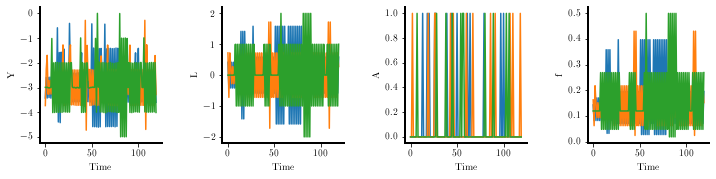

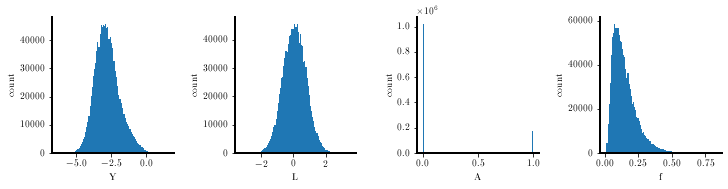

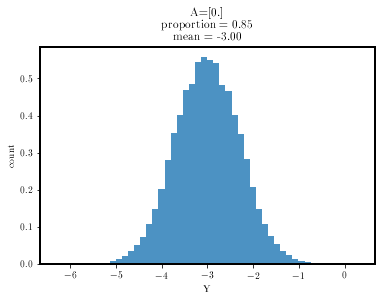

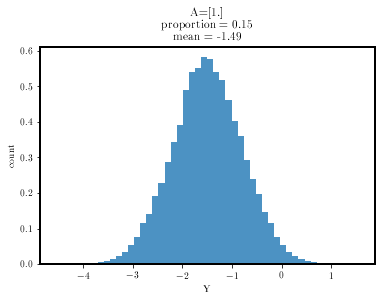

In [8]:
ycoeff = [-3,2,-1] # Y
acoeff = [-2,0.5,-0.5,0.5] # A
lcoeff = [0,1,-1] # L (W)
S=10000
buffer=20
T=100+buffer
mu=0
sigma=0.01
seed=1
simu_data = simulator(ycoeff,acoeff,lcoeff,S, T, mu, sigma, seed=seed, is_plot=1)
simu_settings = [d,ycoeff,acoeff,lcoeff,mu,sigma,S,T,buffer]

# Train CVAE/MSCVAE

Using device: cpu


epoch: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


validation err: 0.26006237


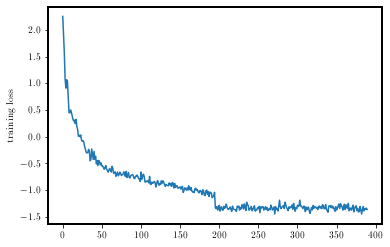

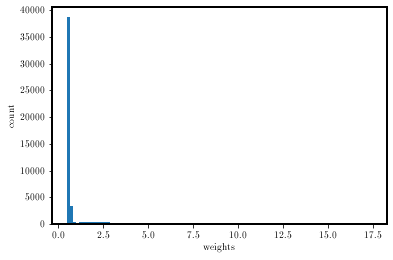

Using device: cpu


epoch: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


validation err: 0.2647316


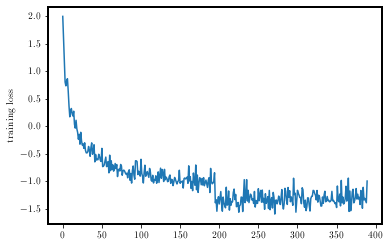

In [9]:
test_size = 1000 # Validation data size (only for training purpose)
layer_width=1000 # CVAE/MSCVAE layer width
batch_size=256 # Training batch size
input_size=1 #input size to the autoencoders (=1 for 1-d outcome vars)
if train_size < batch_size:
    batch_size = train_size
learning_rate=0.001 # Training learning rate
training_set = generate_train_test(simu_data,train_size,test_size,seed)

#filename for saving figures
figname =  'synthetic_d%d_train%d_latent%d_epoch%d'%(d, train_size, latent_dim, epoch)

#If the trained model exists, load models, otherwise, start training.

#CVAE
if os.path.exists('cvae_'+figname+'.pt'):
    print('cvae exists, loading')
    cvae = CVAE(input_size,d,latent_dim,layer_width) 
    cvae.load_state_dict(torch.load('cvae_'+figname+'.pt'))
else:
    cvae,train_losses,validation_losses = train(training_set, hidden_size=latent_dim,layer_width=layer_width,epochs=epoch,batch_size=batch_size,is_msm=0,learning_rate=learning_rate)
    plt.plot(np.log(train_losses))
    plt.ylabel('training loss')
    plt.show()
    torch.save(cvae.state_dict(), 'cvae_'+figname+'.pt')

    
#MSCVAE
if os.path.exists('cvae_w_'+figname+'.pt'):
    print('cvae_w exists, loading')
    cvae_w = CVAE(input_size,d,latent_dim,layer_width)
    cvae_w.load_state_dict(torch.load('cvae_w_'+figname+'.pt'))
else:
    cvae_w,train_losses_w,validation_losses_w = train(training_set, hidden_size=latent_dim,layer_width=layer_width,epochs=epoch,batch_size=batch_size,is_msm=1,learning_rate=learning_rate)
    plt.plot(np.log(train_losses_w))
    plt.ylabel('training loss')
    plt.show()
    torch.save(cvae_w.state_dict(), 'cvae_w_'+figname+'.pt')

# Obtain counterfactual and learned samples for the outcome

In [10]:
# Draw the samples
Y_trues_simu,cvae_sample,cvae_w_sample = draw_samples(simu_settings,cvae,cvae_w,training_set)

# Save the samples
sio.savemat(figname+'_data.mat', mdict={'Y_trues_simu':Y_trues_simu,'cvae_sample':cvae_sample,'cvae_w_sample':cvae_w_sample})

# Visualize learned distributions

d=1


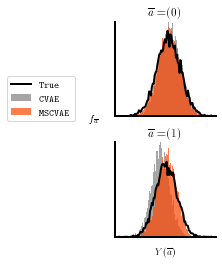

synthetic_d1_train50000_latent5_epoch100
CVAE   mean: 0.242, wasserstein: 0.248
MSCVAE   mean: 0.030, wasserstein: 0.067


In [19]:
# plot and print results
results = plot_compute(d,Y_trues_simu,cvae_sample,cvae_w_sample,figname)